In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import utils as ut

2023-06-08 15:24:46.347898: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-08 15:24:46.389381: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from tqdm import tqdm

# import the tracks

In [14]:
df_tracks = pd.read_csv('/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/20230526_Rad21-Halo_NIPBL_1C5_0h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB/tracks_corrected__20230526_Rad21-Halo_NIPBL_1C5_0h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB.csv')

In [4]:
def get_gaps(df:pd.DataFrame) -> pd.DataFrame:
    """
    :param df: track dataframe
    :return: a pandas dataframe with gaps per track id
    """
    df = df.reset_index()
    df = df[['x','y','frame','track_id']]
    df['frame'] = df['frame'].astype(int)
    df = df.sort_values(by=['track_id','frame'])
    df['frame_diff'] = df['frame'].diff()
    df['frame_diff'] = df['frame_diff'].fillna(0)
    df['frame_diff'] = df['frame_diff'].astype(int)
    df['gaps'] = 0
    df.loc[df['frame_diff'] > 1,'gaps'] = df['frame_diff'] - 1
    # df = df.drop(columns=['frame_diff'])
    return df

In [17]:
df_gaps = get_gaps(df_tracks)

In [18]:
df_gaps

,x,y,frame,track_id,frame_diff,gaps
198312,455.071029,1.493885,0,1,0,0
198345,455.185457,1.756226,2,1,2,1
198355,454.705973,3.008206,3,1,1,0
198433,457.817763,0.069945,7,1,4,3
198474,455.802803,-0.062439,9,1,2,1
...,...,...,...,...,...,...
161972,67.336761,431.644885,178,27823,-1,0
162032,65.851732,431.970363,180,27823,2,1
81289,154.343480,213.379048,178,27825,-2,0
81338,153.828339,215.361423,179,27825,1,0


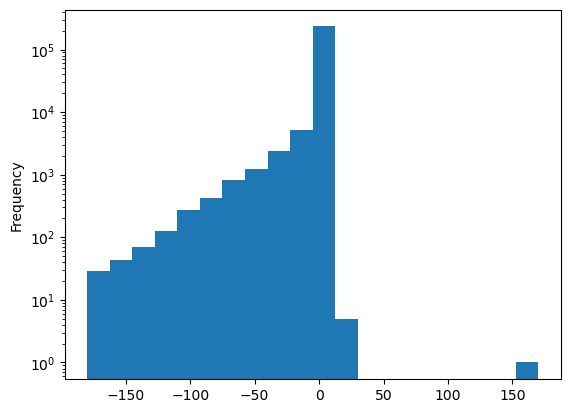

In [23]:
df_gaps.frame_diff.plot(kind='hist',bins=20)
# plt.xlim(0,30)
plt.yscale('log')

In [42]:
df_filtered = df_tracks[df_tracks.frame > 90]

In [35]:
print(len(df_tracks))
print(len(df_filtered))
print(len(df_filtered)/len(df_tracks))

243916
60892
0.24964331983141738


In [43]:
df_filtered = ut.filter_tracks(df_filtered)

In [44]:
df_list = []
for i in tqdm(df_filtered.channel.unique()):
    df_chanel = df_filtered[df_filtered.channel == i]
    df_chanel = ut.calculate_all_tamsd(df_chanel)
    df_chanel['tamsd'] = df_chanel['tamsd'] * 1.5 # scalling factor for 3D to 2D MSD
    df_chanel['channel'] = [i] * len(df_chanel)
    df_list.append(df_chanel)

df_msd = pd.concat(df_list)

100%|██████████| 2/2 [00:31<00:00, 15.55s/it]


In [17]:
df_msd

,lags,tamsd,weight,uniqueid,track_id,trStart,channel
0,1,1.561185,30,54ca6dc5ebe2dbd0,254,0,w1
1,2,2.677978,29,54ca6dc5ebe2dbd0,254,0,w1
2,3,3.771979,28,54ca6dc5ebe2dbd0,254,0,w1
3,4,4.773729,27,54ca6dc5ebe2dbd0,254,0,w1
4,5,5.765204,26,54ca6dc5ebe2dbd0,254,0,w1
...,...,...,...,...,...,...,...
27,28,8.861939,17,48c1c188030cf34c,26268,59,w2
28,29,7.471029,13,48c1c188030cf34c,26268,59,w2
29,30,10.350848,14,48c1c188030cf34c,26268,59,w2
30,31,8.724639,14,48c1c188030cf34c,26268,59,w2


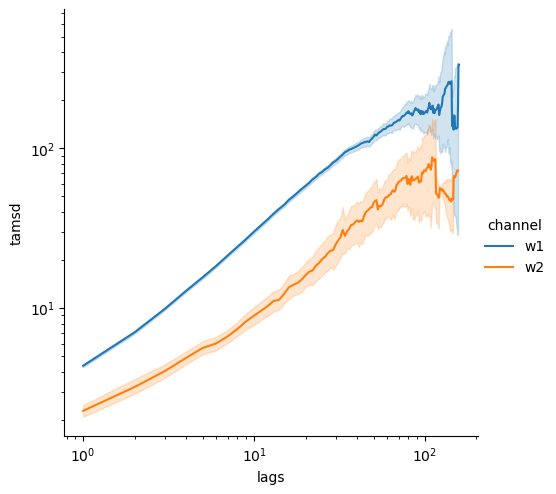

In [18]:
sns.relplot(data=df_msd, x='lags', y='tamsd', hue='channel', kind='line')
plt.xscale('log')
plt.yscale('log')

In [46]:
df_untreated = pd.read_csv('/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/df_untreated.csv')

In [45]:
df_untreated

,Unnamed: 0.1,Unnamed: 0,lags(s),MSD(µm^2),weight,uniqueid,track_id,trStart,channel,cell_type,treatment,correction,file
0,0,0,10.0,0.041686,21.0,c62f66cc1152e68a,79,0,cohesin,NIPBL,untreated,corrected,20230529_Rad21-Halo_NIPBL_1C5_0h_1_FullseqTIRF...
1,1,1,20.0,0.049861,21.0,c62f66cc1152e68a,79,0,cohesin,NIPBL,untreated,corrected,20230529_Rad21-Halo_NIPBL_1C5_0h_1_FullseqTIRF...
2,2,2,30.0,0.073884,21.0,c62f66cc1152e68a,79,0,cohesin,NIPBL,untreated,corrected,20230529_Rad21-Halo_NIPBL_1C5_0h_1_FullseqTIRF...
3,3,3,40.0,0.103948,20.0,c62f66cc1152e68a,79,0,cohesin,NIPBL,untreated,corrected,20230529_Rad21-Halo_NIPBL_1C5_0h_1_FullseqTIRF...
4,4,4,50.0,0.103560,19.0,c62f66cc1152e68a,79,0,cohesin,NIPBL,untreated,corrected,20230529_Rad21-Halo_NIPBL_1C5_0h_1_FullseqTIRF...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1249300,111646,10,110.0,0.141185,14.0,16447e7eadf9278b,47574,148,DNA,WT,untreated,corrected,20230605_Rad21-Halo_G6_3_FullseqTIRF-Cy5-mCher...
1249301,111647,11,120.0,0.150271,13.0,16447e7eadf9278b,47574,148,DNA,WT,untreated,corrected,20230605_Rad21-Halo_G6_3_FullseqTIRF-Cy5-mCher...
1249302,111648,12,130.0,0.144934,12.0,16447e7eadf9278b,47574,148,DNA,WT,untreated,corrected,20230605_Rad21-Halo_G6_3_FullseqTIRF-Cy5-mCher...
1249303,111649,13,140.0,0.130239,11.0,16447e7eadf9278b,47574,148,DNA,WT,untreated,corrected,20230605_Rad21-Halo_G6_3_FullseqTIRF-Cy5-mCher...


In [47]:
df_msd.tamsd = df_msd.tamsd * (0.160**2) - (2*(0.035**2))
df_msd.lags = df_msd.lags * 10 

df_msd.rename(columns={'tamsd': 'MSD(µm^2)', 'lags': 'lags(s)'}, inplace=True)
df_msd['cell_type'] = ['end of movie'] * len(df_msd)
df_msd.track_id = df_msd.track_id + 10000

In [48]:
df_msd.replace('w1','cohesin', inplace=True)
df_msd.replace('w2','DNA', inplace=True)

In [49]:
df_comb = pd.concat([df_untreated[['MSD(µm^2)','lags(s)','uniqueid','track_id','cell_type','channel']], df_msd])

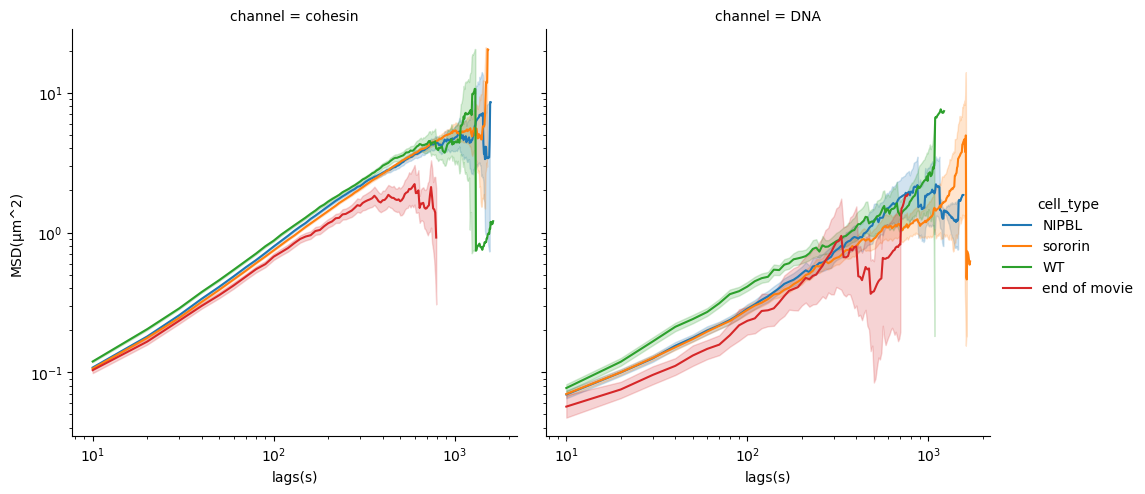

In [50]:
sns.relplot(data=df_comb, x='lags(s)', y='MSD(µm^2)', hue='cell_type', kind='line', col='channel')
plt.xscale('log')
plt.yscale('log')
# plt.savefig('/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/MSD_untreated_end_of_movie.png', dpi=300)

In [62]:
def get_D_alpha(traj, min_length=10, numPoints=5):
    if traj.shape[0]<min_length:
        return np.nan, np.nan, np.nan, np.nan,np.nan
    model = LinearRegression()
    x = np.log10(traj.loc[:,"lags(s)"])
    y = np.log10(traj.loc[:,"MSD(µm^2)"])
    # sampleWeight = traj.loc[traj.correction=="corrected","weight"]
    #print(x.to_numpy().reshape(-1,1)[:numPoints], y.to_numpy()[:numPoints], sampleWeight.to_numpy()[:numPoints])
    model.fit(x.to_numpy().reshape(-1,1)[:numPoints], y.to_numpy()[:numPoints])#, sample_weight = sampleWeight.to_numpy()[:numPoints])
    y_pred = model.predict(x.to_numpy().reshape(-1,1))
    return model.intercept_, model.coef_[0]#,traj.iloc[0].treatment,traj.iloc[0].file,traj.iloc[0].channel#10**y_pred,10**x

In [60]:
from sklearn.linear_model import LinearRegression

In [64]:
coefficients = df_msd.groupby(by="uniqueid").apply(get_D_alpha, min_length=10, numPoints=5).to_frame()

In [65]:
coefficients['D'], coefficients['alpha'] = zip(*coefficients.iloc[:,0])
coefficients['D'] = 10**coefficients['D']
coefficients.drop(columns=[0],inplace=True)

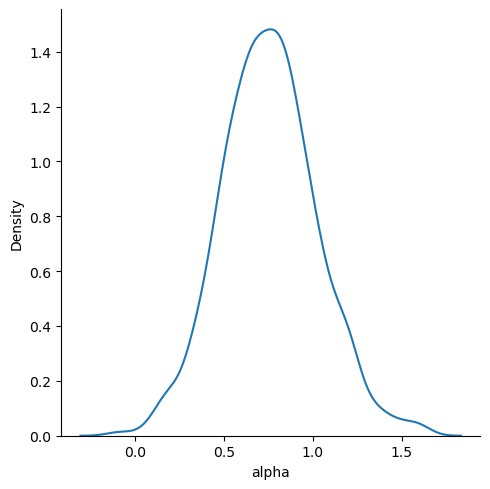

In [66]:
sns.displot(data=coefficients, x="alpha", kind="kde",common_norm=False)

In [67]:
coefficients.alpha.median()

0.7461325263944185

In [69]:
coefficients.alpha.std()

0.2681520352002636

In [32]:
df_msd.to_csv('/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/df_msd_nipbl_untreated_cropped_end_of_movie.csv', index=False)

In [25]:
df_filtered

,Unnamed: 0.1,Unnamed: 0,x,y,frame,track_id,label,channel,z,xres,yres,zres,degree_av_rotation,degree_av_translation
0,180,254,286.513552,188.935466,0,254,1,w1,0.0,0.000000,0.000000,0.0,0.006630,2.543294
1,185,259,281.900567,189.110493,0,259,1,w1,0.0,0.000000,0.000000,0.0,0.006630,2.543294
3,196,273,307.355845,195.128765,0,273,1,w1,0.0,0.000000,0.000000,0.0,0.006630,2.543294
7,215,292,261.546093,207.499084,0,292,1,w1,0.0,0.000000,0.000000,0.0,0.006630,2.543294
8,218,295,317.844101,208.076664,0,295,1,w1,0.0,0.000000,0.000000,0.0,0.006630,2.543294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243891,235620,267259,403.027812,187.239195,180,10152,53,w1,0.0,-6.978531,11.697217,0.0,0.007214,3.181476
243897,235752,267443,372.420874,175.969033,180,9692,53,w1,0.0,-7.141925,12.131406,0.0,0.007214,3.181476
243898,235755,267446,357.640554,185.301881,180,17415,53,w1,0.0,-7.010677,12.342574,0.0,0.007214,3.181476
243901,235844,267566,372.353907,208.926867,180,3783,53,w1,0.0,-6.673165,12.135693,0.0,0.007214,3.181476


In [86]:
df_filtered.groupby('track_id').count().sort_values(by='x', ascending=False).index.values[:10]

array([13020,  9352,  8032,  4665, 13481,  1971, 12563,  9692, 26569,
        7556])

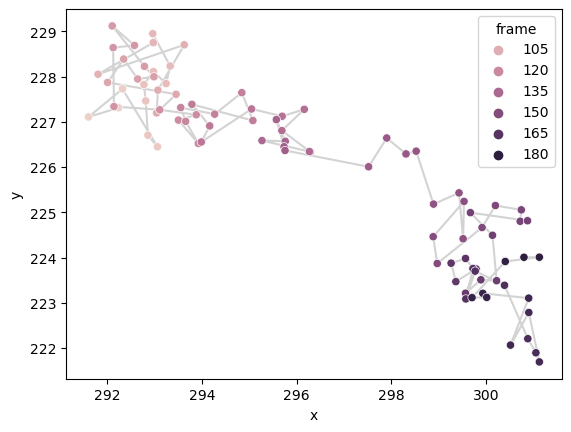

In [55]:
track = df_filtered[df_filtered.track_id == 4665]

sns.scatterplot(data=track, x='x', y='y', hue='frame')
plt.plot(track.x, track.y, color='lightgray',zorder=0)

In [73]:
df_tracks = pd.read_csv('/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/20230526_Rad21-Halo_NIPBL_1C5_0h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB/tracks_merged__20230526_Rad21-Halo_NIPBL_1C5_0h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB.csv')

In [ ]:
track_id = 13020

13020


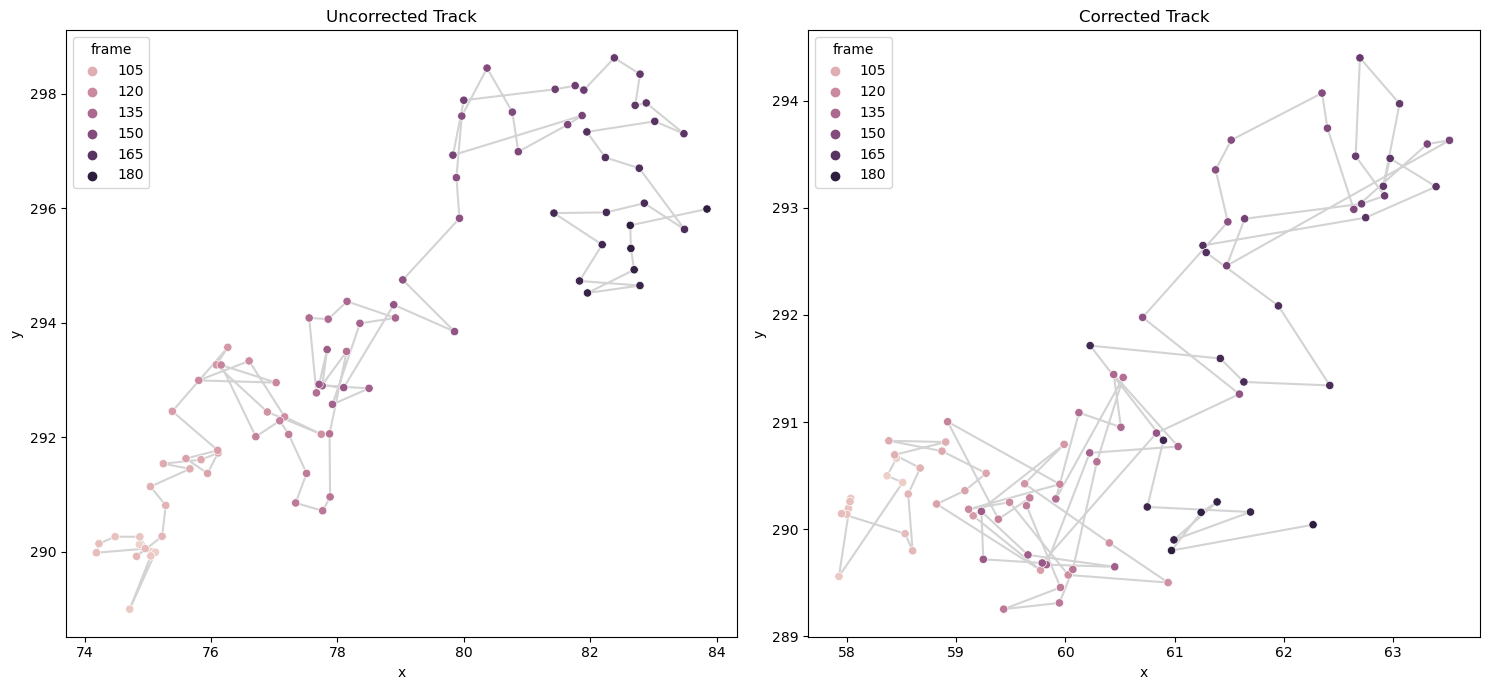

9352


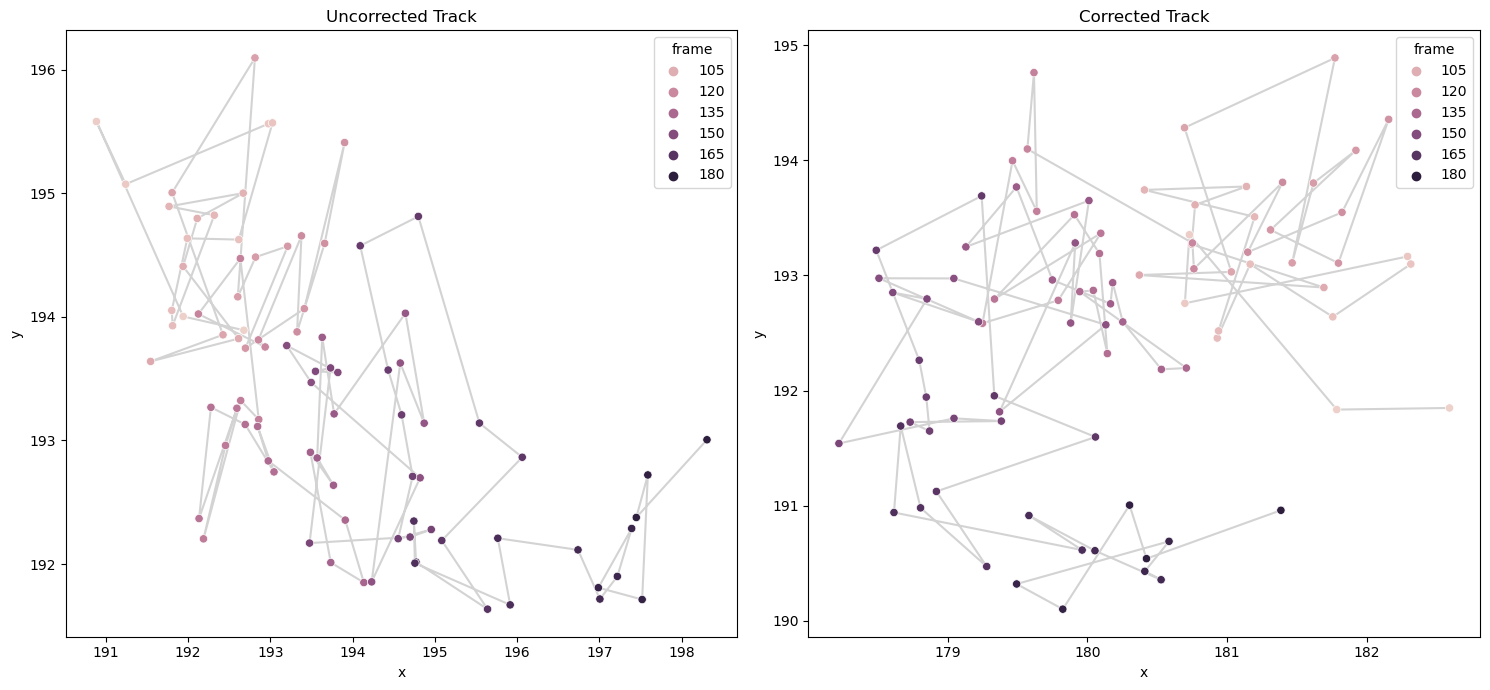

8032


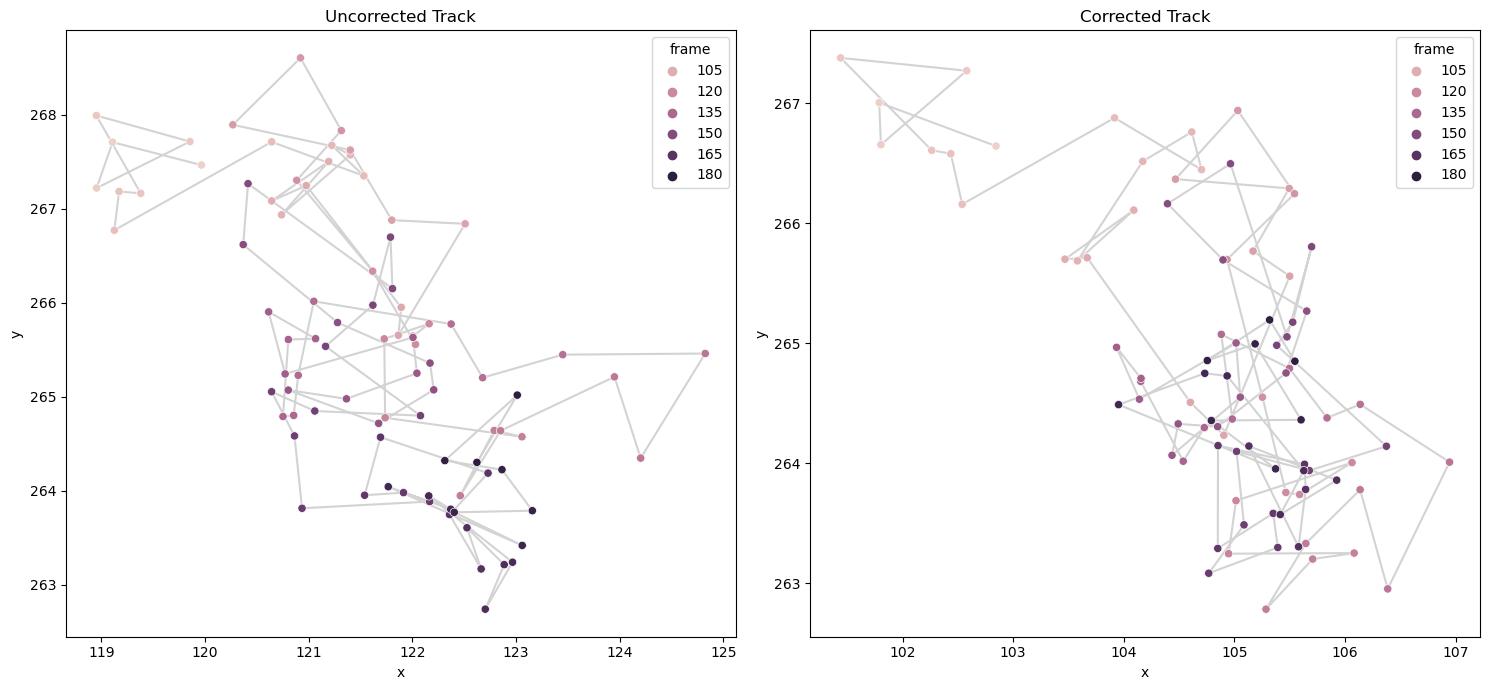

4665


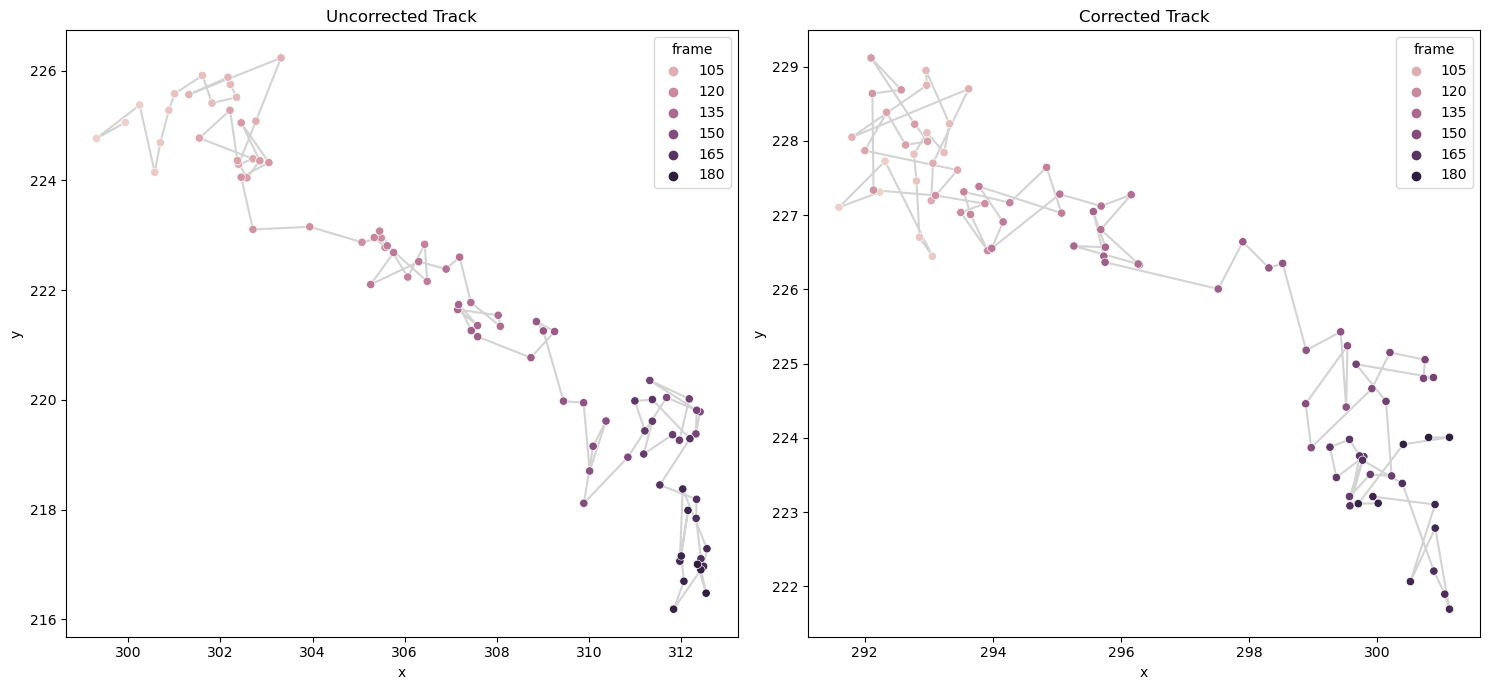

13481


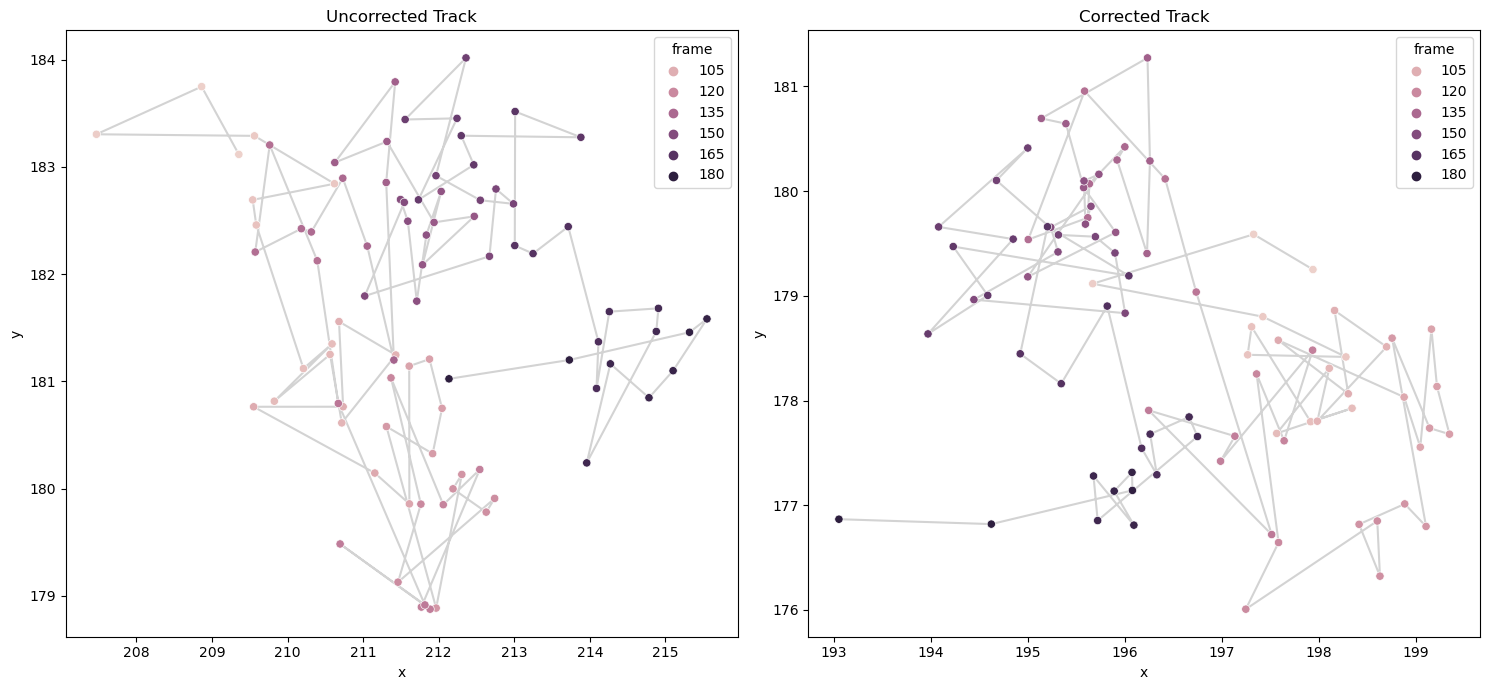

1971


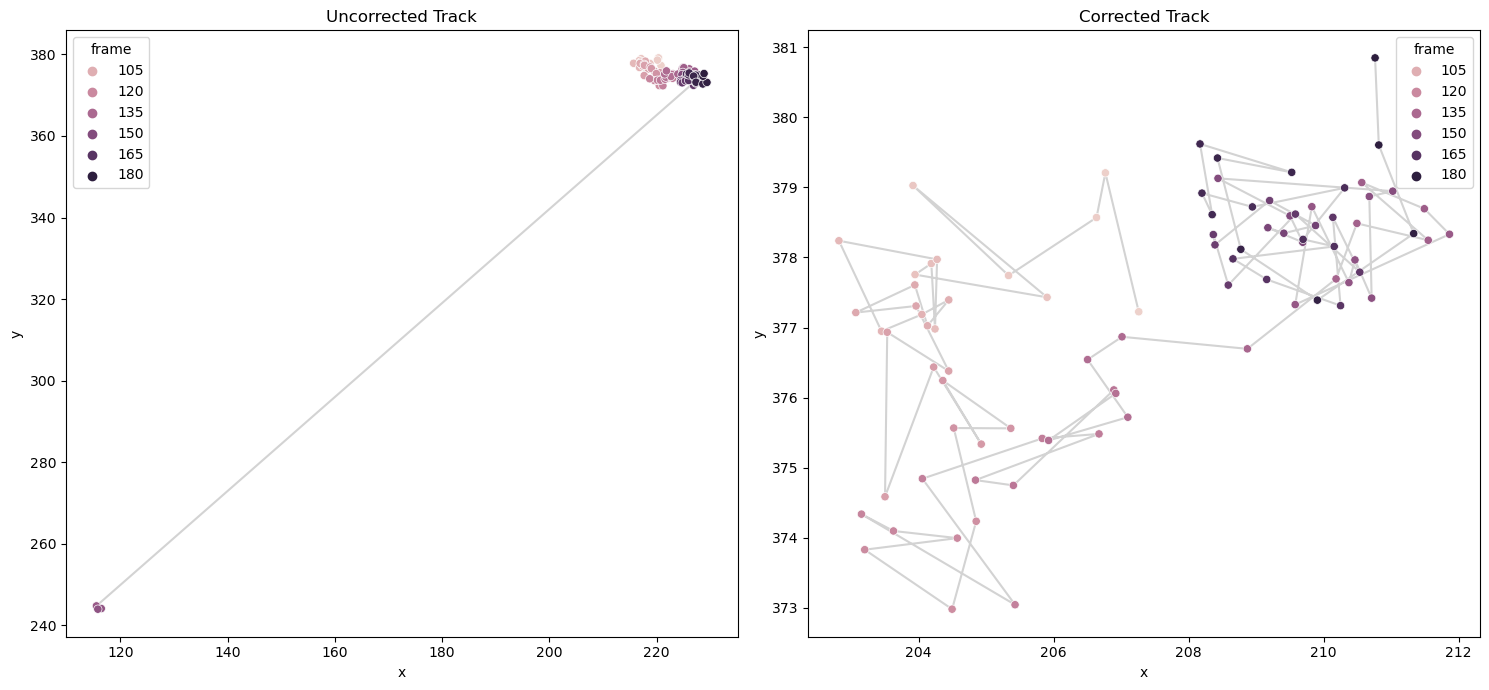

12563


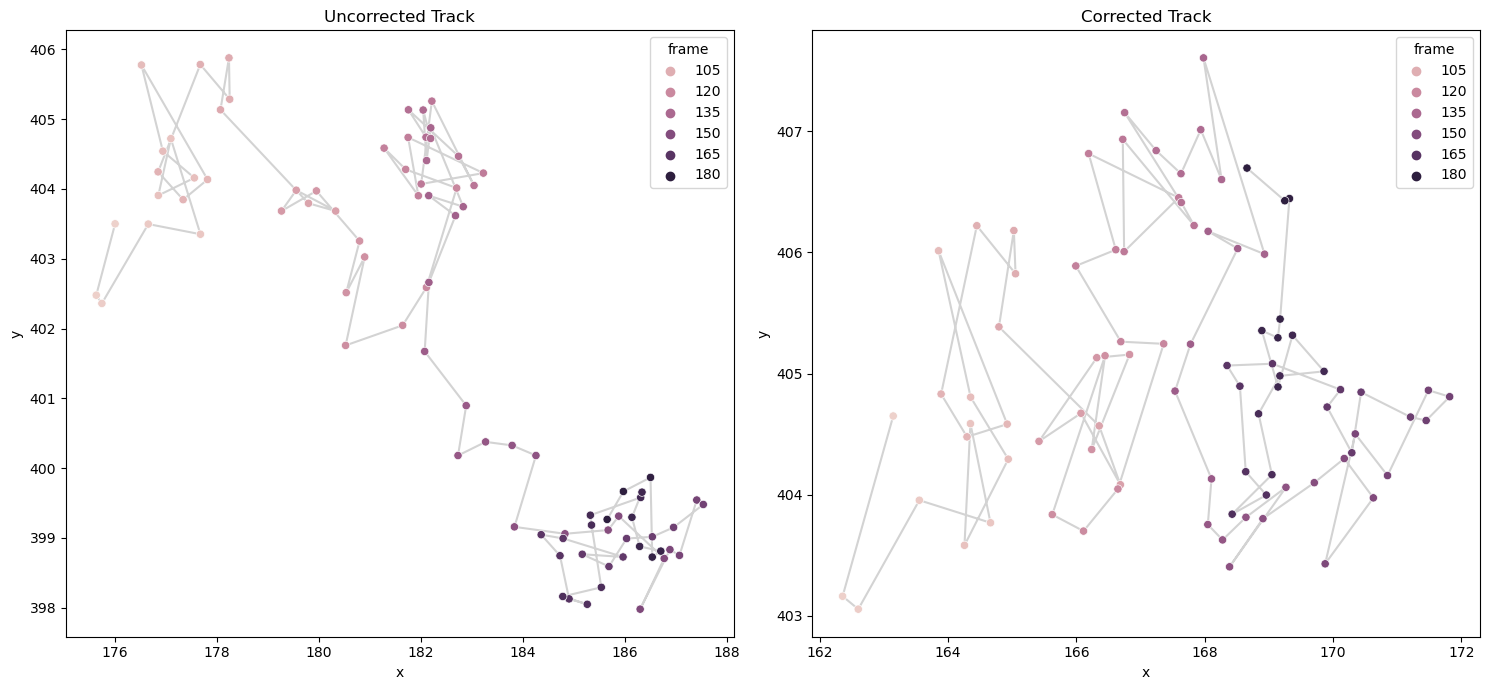

9692


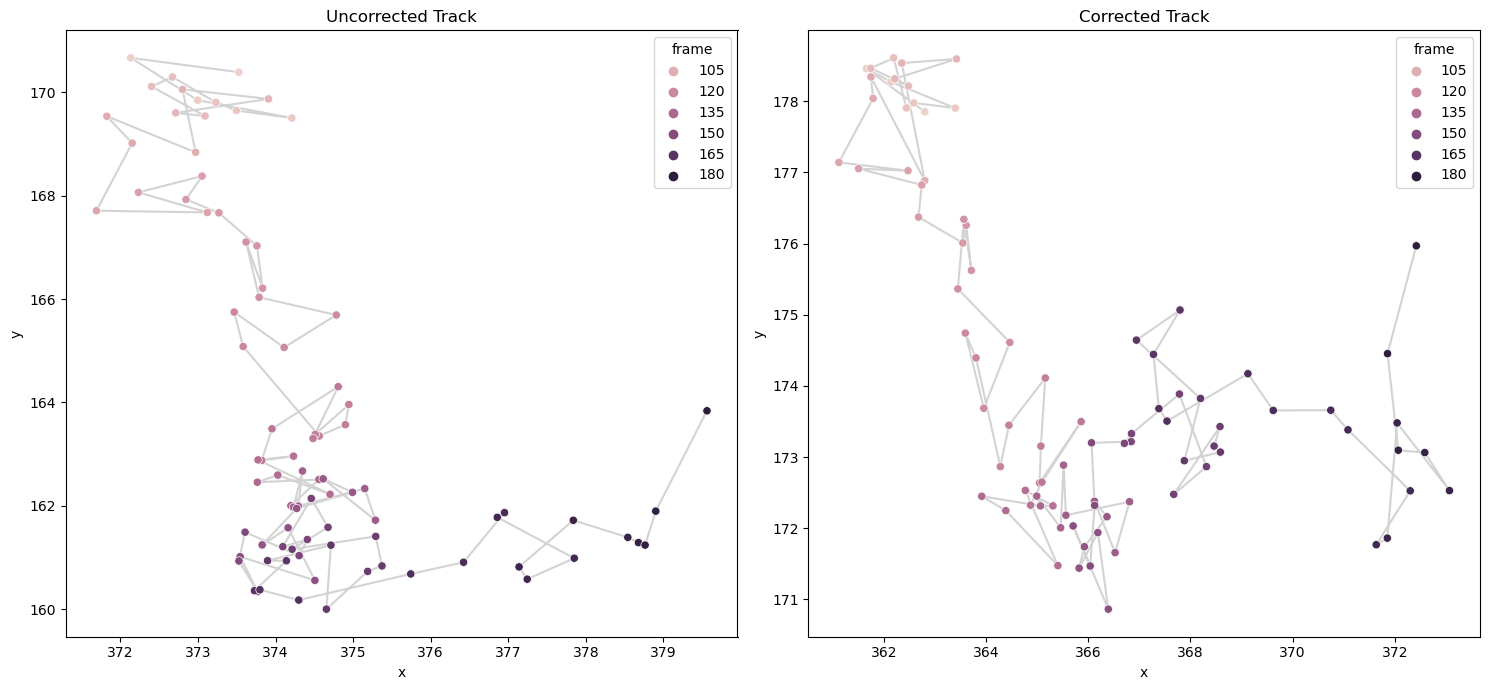

26569


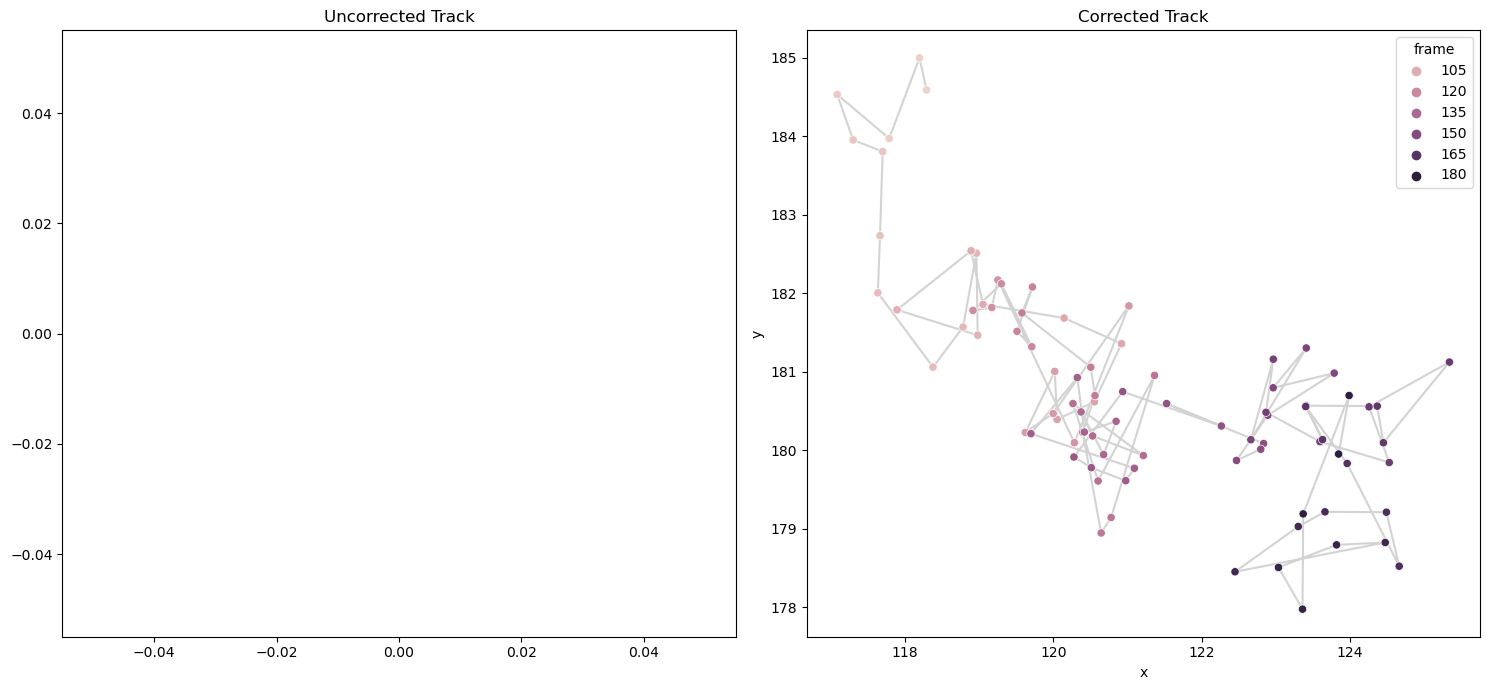

7556


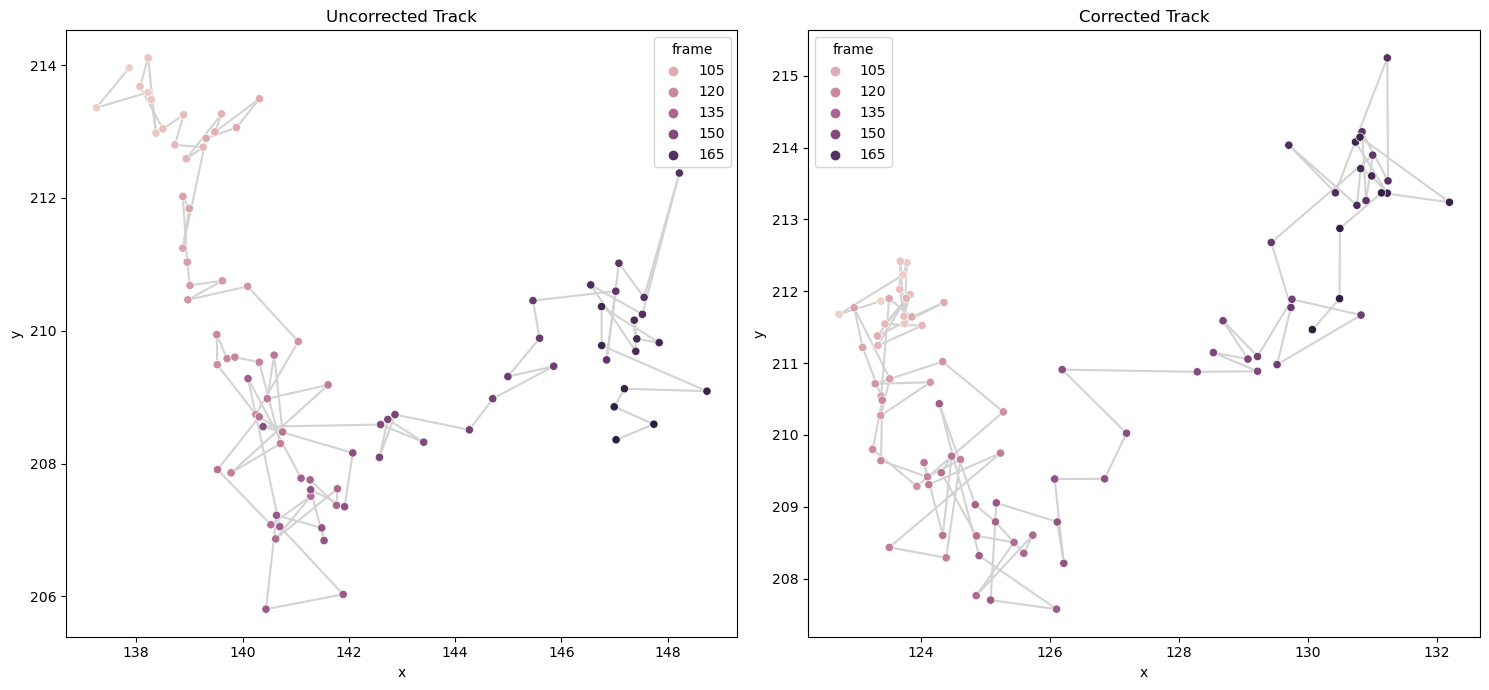

In [106]:

for track_id in df_filtered.groupby('track_id').count().sort_values(by='x', ascending=False).index.values[:10]:
    print(track_id)
    fig,ax = plt.subplots(1,2,figsize=(15,7))
    df_track = df_tracks[(df_tracks.track_id == track_id)&(df_tracks.frame > 90)]
    track = df_filtered[df_filtered.track_id == track_id]

    sns.scatterplot(data=df_track, x='x', y='y', hue='frame',ax=ax[0])
    ax[0].plot(df_track.x, df_track.y, color='lightgray',zorder=0)
    ax[0].set_title('Uncorrected Track')

    sns.scatterplot(data=track, x='x', y='y', hue='frame',ax=ax[1])
    ax[1].plot(track.x, track.y, color='lightgray',zorder=0)
    ax[1].set_title('Track')
    ax[1].set_title('Corrected Track')

    fig.tight_layout()
    plt.show()

# for a in ax:
#     a.set_aspect('equal')
#     a.set_xlim(290,320)
#     a.set_ylim(212,230)

In [110]:
track.y.min()

207.57572454698584

In [89]:
from tifffile import imread

In [90]:
im = imread('/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/images/20230526_Rad21-Halo_NIPBL_1C5_0h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB_w1.tif')

In [91]:
im.shape

(181, 5, 512, 512)

In [92]:
im_max = np.max(im[90:,...], axis=1)

In [93]:
im_max.shape

(91, 512, 512)

In [95]:
from matplotlib import animation
from IPython.display import HTML

In [100]:
track.x.values[0]

123.37902880025474

In [116]:
track.y.values[0]

211.864640120414

In [139]:
track[track.frame == 91+87]

,Unnamed: 0.1,Unnamed: 0,x,y,frame,track_id,label,channel,z,xres,yres,zres,degree_av_rotation,degree_av_translation
149303,234482,265871,130.069641,211.466657,178,7556,10,w1,0.0,-16.960125,3.108383,0.0,0.005201,1.405612


(200.0, 215.0)

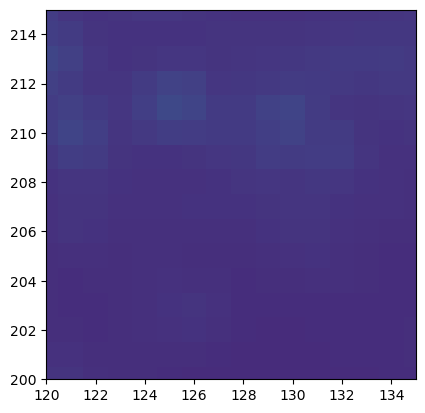

In [146]:
plt.imshow(im_max[0,...],vmin=0,vmax=65000)
plt.xlim(120,135)
plt.ylim(200,215)

In [152]:
df_track.y.min()

205.80767897994733

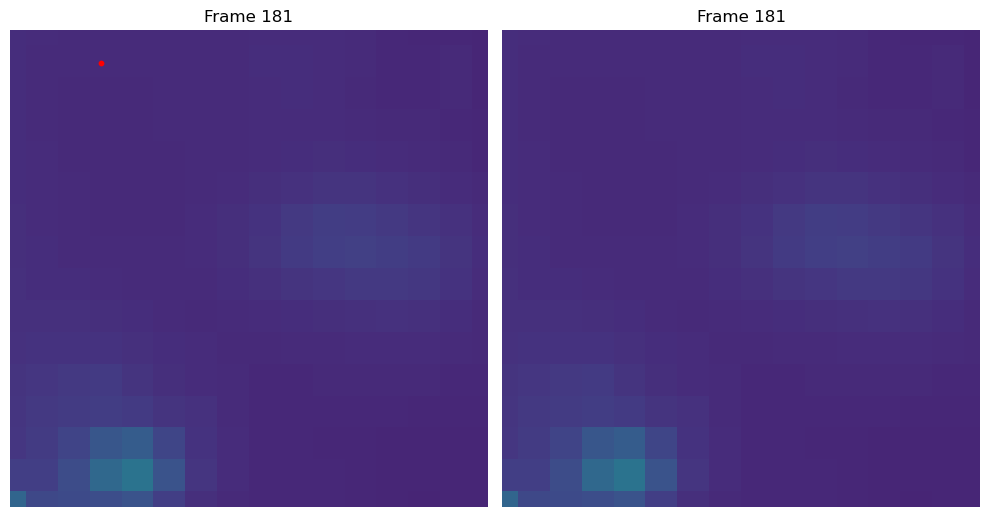

In [158]:

fig, ax = plt.subplots(1,2,figsize=(10, 10))
for a in ax:
    a.axis('off')
    a.set_xlim(135,150)
    a.set_ylim(200,215)

im = ax[0].imshow(im_max[0,...],animated = True)
over = ax[1].imshow(im_max[0,...])
scat = ax[0].scatter(x=df_track.x.values[0], y=df_track.y.values[0], color='red', s=10)
fig.tight_layout()

def update(t):
    im.set_data(A_anim[t,...])
    over.set_data(A_anim_2[t,...])
    lastx = df_track.x.values[0]
    lasty = df_track.y.values[0]
    if df_track[df_track.frame == 91+t].empty:

        x= lastx
        y = lasty

    else:

        x= df_track[df_track.frame == 91+t].x.values[0]
        y = df_track[df_track.frame == 91+t].y.values[0]
        lastx = x
        lasty = y

    scat.set_offsets([x,y])
    for a in ax:
        a.set_title(f'Frame {91+t}')
    return [im,over]


nb_times_im = np.shape(im_max)[0]

A_anim = im_max[::im_max.shape[0]//nb_times_im ,...]
A_anim_2 = im_max[::im_max.shape[0]//nb_times_im ,...]

anim = animation.FuncAnimation(fig, update,
                               frames=nb_times_im, interval=50, 
                               blit=True)

HTML(anim.to_jshtml())

In [156]:
f = "plots/test_track_gif.gif"
writergif = animation.PillowWriter(fps=3) 
anim.save(f, writer=writergif)

In [165]:
import matplotlib

In [170]:
f = "plots/animationtest_track.mp4" 

matplotlib.rcParams['animation.ffmpeg_path'] = "C:\\Users\\louaness\\Downloads\\ffmpeg-master-latest-win64-gpl\\ffmpeg-master-latest-win64-gpl\\bin\\ffmpeg.exe"

writer = animation.FFMpegWriter(fps=60, metadata=dict(artist='Me'), bitrate=1800)
anim.save(f,writer=writer)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\louaness\\Downloads\\ffmpeg-master-latest-win64-gpl\\ffmpeg-master-latest-win64-gpl\\bin\\ffmpeg.exe'